# Import and save individual vectors and image as npz (time-series)

In [5]:
from os import listdir
from numpy import asarray
from numpy import load
import numpy as npg
from numpy import savez_compressed
from data_loader import *

In [6]:
%%time
path = 'E:\\Data'

# Length of trajectory vector
obs_len = 10
future_len = 20
start_idx = 200


for foldername in listdir(path):
    data_x = list()
    data_y = list()
    # load target dataset
    loader = DataLoader(base_path='E:\\Data', dataset_name=foldername)
    seq_len = loader.data.shape[0]
    print('>> current folder: ' + foldername)
    for i in range(start_idx, seq_len - future_len - 1):
        # calibration params
        K = loader.K
        Rt = loader.Rt
        # current frame data
        cur_data = loader.data[i-obs_len: i+future_len]
        # transformation matrix (global to egocentric)
        Mt = loader.create_pose_matrix(cur_data[obs_len][1], cur_data[obs_len][2], cur_data[obs_len][3],cur_data[obs_len][4], cur_data[obs_len][6], cur_data[obs_len][7])
        # global trajectory in homo
        global_traj_xy = cur_data[:, 6:8]
        global_traj_alt = cur_data[:, 1].reshape(global_traj_xy.shape[0], 1) - 0.35
        global_traj_homo = np.concatenate([global_traj_xy, global_traj_alt, np.ones(shape=(global_traj_xy.shape[0], 1))], axis=1)
        # ego-centric traj
        ego_traj = np.matmul(Mt, global_traj_homo.T).T
        data_y.append(ego_traj)
        # draw trajectory 
        img = loader.read_image_exp(cur_data[obs_len, 8], (256, 256))
        data_x.append(img)
    data_x, data_y = asarray(data_x), asarray(data_y)
    savez_compressed(foldername + '.npz', data_x, data_y)
        

>> current folder: 0000


KeyboardInterrupt: 

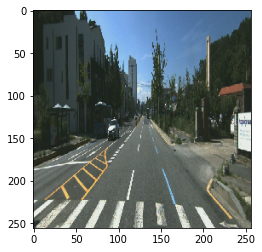

In [8]:
# Show image
from matplotlib import pyplot
pyplot.imshow(data_x[1].astype('uint8'))

In [ ]:
# Load npz dataset
%%time 
data = load('0000.npz')
data_x, data_y = data['arr_0'], data['arr_1']

# Overlay vectors into image and save as npz (Pix2Pix Dataset)

In [9]:
from os import listdir
from numpy import asarray
from numpy import load
import numpy as npg
from numpy import savez_compressed
from data_loader import *
from matplotlib import pyplot as plt

In [10]:
# Overlays trajectory in image using the image (data_x) and position vector (data_y)
def create_trajectory(data_x, data_y, obs_len=10):
    # Calibrated coefficient matrix to overlay image into 1260x360 resolution image
    K = np.array([[537.023764, 0, 640 , 0], 
                [0 , 537.023764, 180, 0], 
                    [0, 0, 1, 0]])
    Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                        [-0.999575,  0.004514,  0.028809,  0.296583],
                        [ 0.004305,  0.999964, -0.007316, -1.544537],
                        [ 0.      ,  0.      ,  0.      ,  1.      ]])

    # Resize image back to 1280x360
    cv2_image = data_x.astype('uint8')
    cv2_image = cv2.resize(cv2_image, (1280,360))

    # Draw points in the given image (data_x)
    for m in range(obs_len, data_y.shape[0]):
        A = np.matmul(np.linalg.inv(Rt), data_y[m, :].reshape(4, 1))
        B = np.matmul(K, A)

        x = int(B[0, 0] * 1.0 / B[2, 0])
        y = int(B[1, 0] * 1.0 / B[2, 0])
        if (x < 0 or x > 1280 - 1 or y > 360 - 1):
            continue
        # Draw trajectory vector
        cv2_image = cv2.circle(cv2_image, (x, y), 3, (0, 0, 255), -1)
    # Resize back to original shape
    cv2_image = cv2.resize(cv2_image, (data_x.shape[0],data_x.shape[1]))
    return cv2_image

In [29]:
%%time
path = 'E:\\Data'

obs_len = 10
future_len = 30
start_idx = 200

p = 0

for foldername in listdir(path):
    if p!=0:
        p -= 1
        continue
    data_x = list()
    data_y = list()
    # load target dataset
    loader = DataLoader(base_path='E:\\Data', dataset_name=foldername)
    seq_len = loader.data.shape[0]
    print('>> current folder: ' + foldername)
    for i in range(start_idx, seq_len - future_len - 1):
        # calibration params
        K = loader.K
        Rt = loader.Rt
        # current frame data
        cur_data = loader.data[i-obs_len: i+future_len]
        # transformation matrix (global to egocentric)
        Mt = loader.create_pose_matrix(cur_data[obs_len][1], cur_data[obs_len][2], cur_data[obs_len][3],cur_data[obs_len][4], cur_data[obs_len][6], cur_data[obs_len][7])

        # global trajectory in homo
        global_traj_xy = cur_data[:, 6:8]
        global_traj_alt = cur_data[:, 1].reshape(global_traj_xy.shape[0], 1) - 0.35
        global_traj_homo = np.concatenate([global_traj_xy, global_traj_alt, np.ones(shape=(global_traj_xy.shape[0], 1))], axis=1)

        # ego-centric traj
        ego_traj = np.matmul(Mt, global_traj_homo.T).T
        
        # draw trajectory on left image and write driving action on the image
        img = loader.read_image_exp(cur_data[obs_len, 8], (256, 256))
        img_traj = create_trajectory(img, ego_traj)

        img = img.astype('float16')
        img = (img - 127.5) / 127.5
        img_traj = img_traj.astype('float16')
        img_traj = (img_traj - 127.5) / 127.5

        data_x.append(img)
        data_y.append(img_traj)
    data_x, data_y = asarray(data_x), asarray(data_y)
    savez_compressed(foldername + '.npz', data_x, data_y)
        

>> current folder: 0000
>> current folder: 0004


KeyboardInterrupt: 

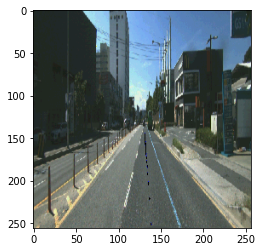

In [48]:
plt.imshow(((data_y[100]+127.5)*127.5).astype('uint8'))

# Show output with trajectory

In [29]:
from data_loader import *

obs_len = 10

K = np.array([[537.023764, 0, 640 , 0], 
            [0 , 537.023764, 180, 0], 
                [0, 0, 1, 0]])
Rt = np.array([[0.028841, 0.007189, 0.999558, 1.481009],
                    [-0.999575,  0.004514,  0.028809,  0.296583],
                    [ 0.004305,  0.999964, -0.007316, -1.544537],
                    [ 0.      ,  0.      ,  0.      ,  1.      ]])

In [3]:
data_y.shape[0]

5866

In [13]:
data_y = np.reshape(data_y, (5866, 40, 4))

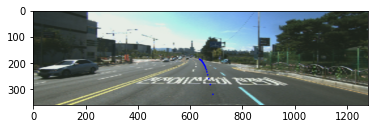

In [6]:
from matplotlib import pyplot as plt
idx = 300
cv2_image = data_x[idx].astype('uint8')
cv2_image = cv2.resize(cv2_image, (1280,360))
p = data_y[idx]

# Draw points
for m in range(obs_len, p.shape[0]):
    A = np.matmul(np.linalg.inv(Rt), p[m, :].reshape(4, 1))
    B = np.matmul(K, A)

    x = int(B[0, 0] * 1.0 / B[2, 0])
    y = int(B[1, 0] * 1.0 / B[2, 0])
    if (x < 0 or x > 1280 - 1 or y > 360 - 1):
        continue
    cv2_image = cv2.circle(cv2_image, (x, y), 3, (0, 0, 255), -1)

plt.imshow(cv2_image)
plt.show()